# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [14]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline


This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


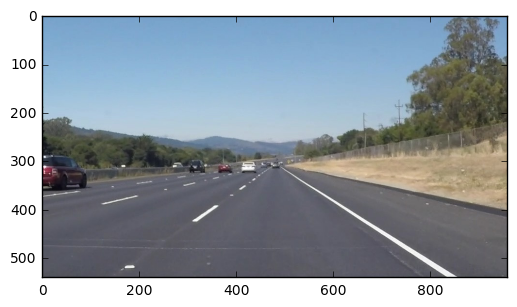

In [15]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [16]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
 
    
    right_slopes = []
    left_slopes = []
    leftx1=leftx2=lefty1=lefty2=rightx1=rightx2=righty1=righty2=0
    # Find the endpoints - the idea is to "smoothen" the line   
    # Now find the slope from the points. I can find this from the en points but the average performs better
 
    # Also added some region of interest / slope checks in here
 
    for line in lines:
        for x1,y1,x2,y2 in line:
           
            if (y2-y1)/(x2-x1) >= 0.5 and (y2-y1)/(x2-x1) < 1.7  :       
                right_slopes.append((y2-y1)/(x2-x1))                 
                if rightx1==0 and rightx2==0:
                # Initialize
                    rightx1 = x1
                    righty1 = y1
                    rightx2 = x2
                    righty2 = y2            
                # find the bottommost point    
                elif x1 < rightx1 and y1> righty1:  
                    rightx1 = x1
                    righty1 = y1
                # find the topmost point    
                elif x2 > rightx2  and y2 < rightx2:  
                    rightx2 = x2
                    righty2 = y2
    
            elif (y2-y1)/(x2-x1) <= -0.5 and (y2-y1)/(x2-x1) > -1.7  :
                left_slopes.append((y2-y1)/(x2-x1)) 
                if leftx1==0 and leftx2==0:
                # Initialize    
                    leftx1 = x1
                    lefty1 = y1
                    leftx2 = x2
                    lefty2 = y2            
                # find the bottommost point    
                elif x1 > leftx1 and y1 > lefty1: 
                    leftx1 = x1
                    lefty1 = y1
                # find the topmost point    
                elif x2 < leftx2 and y2 < lefty2:  
                    leftx2 = x2
                    lefty2 = y2

    right_slope = sum(right_slopes)/len(right_slopes)
    left_slope = sum(left_slopes)/len(left_slopes)

    # extrapolate where the points on the bottom and top edges
    # some are approximations using the bottom and topmost points
    righty1 = img.shape[1]
    rightx1 = int(rightx2 - (righty2-righty1)/right_slope)
    if rightx2 > 520:
        rightx2 = 525
        righty2= int(right_slope*(rightx2-rightx1)+righty1)
        #rightx2 = int( (righty2-righty1)/right_slope + rightx1)

    lefty1 = img.shape[1]
    leftx1 = int(leftx2 - (lefty2-lefty1)/left_slope)
    
    if leftx2 < 440:
        leftx2 = 445
        lefty2= int(left_slope*(leftx2-leftx1)+lefty1)   
        #leftx2 = int( (lefty2-lefty1)/left_slope + leftx1)
            
    # draw the lines
    cv2.line(img, (leftx1, lefty1), (leftx2, lefty2), color, thickness)
    cv2.line(img, (rightx1,righty1), (rightx2, righty2), color, thickness)
    
    
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [17]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg']

run your solution on all test_images and make copies into the test_images directory).

This image solidYellowLeft.jpg is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


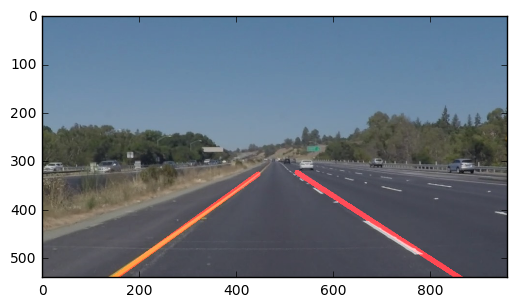

This image solidWhiteRight.jpg is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


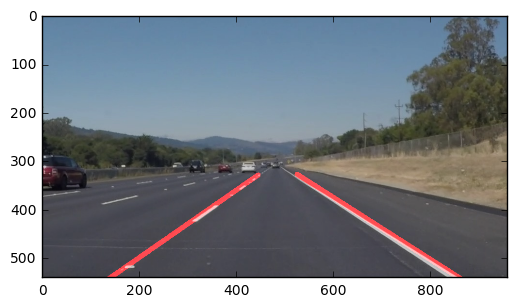

This image solidWhiteCurve.jpg is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


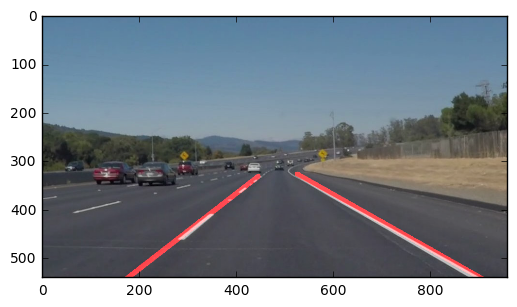

This image whiteCarLaneSwitch.jpg is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


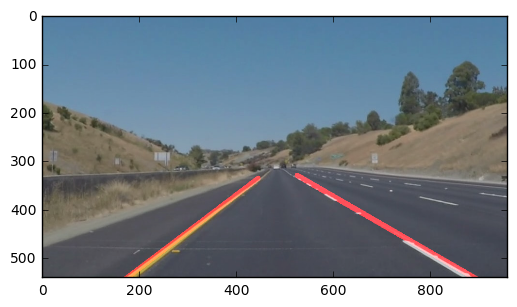

This image solidYellowCurve.jpg is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


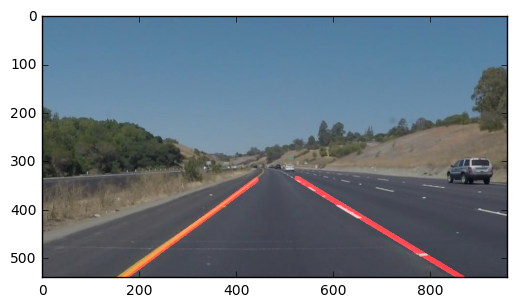

This image solidYellowCurve2.jpg is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


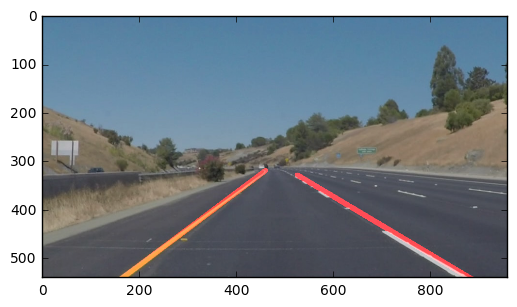

In [18]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

directory = 'test_images/'

def draw_lanes(img):
    #Step by Step approach for ease of debugging - can be done in fewer lines
    gray_img  = grayscale(img)
    blur_img  = gaussian_blur(gray_img,5)
    canny_img = canny(blur_img,45,150)
    
    imshape   = canny_img.shape    
    poly_img  = region_of_interest(canny_img, np.array([[(0,imshape[0]),(450, 320), (530, 320), (imshape[1],imshape[0])]], dtype=np.int32))       
    hough_img = hough_lines(poly_img,2,np.pi/180,15,40,20)   

    return weighted_img(hough_img,img)

for filename in os.listdir(directory):
        img = mpimg.imread(directory+filename)
        if not filename.startswith('WithLanes_'):
            print('This image',filename ,'is:', type(img), 'with dimesions:', img.shape)
            lane_img=draw_lanes(img)
            plt.imshow(lane_img)
            plt.show()
            mpimg.imsave(directory+'WithLanes_'+filename,lane_img)
     

        

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
def process_image(image):

    # The only difference is tried a different thresholds in here to manage gaps
    gray_image  = grayscale(image)
    blur_image  = gaussian_blur(gray_image,5)
    canny_image = canny(blur_image,50,150)
    
    imshape   = canny_image.shape    
    poly_image  = region_of_interest(canny_image, np.array([[(0,imshape[0]),(450, 320), (530, 320), (imshape[1],imshape[0])]], dtype=np.int32))       
    hough_image = hough_lines(poly_image,2,np.pi/180,15,30,30)   

    return weighted_img(hough_image,image)
   
    #return result

Let's try the one with the solid white lane on the right first ...

In [21]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:22<00:00,  8.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2min 10s, sys: 11.5 s, total: 2min 22s
Wall time: 24.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [23]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [01:18<00:00, 11.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 7min 6s, sys: 38 s, total: 7min 44s
Wall time: 1min 20s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

MY RELECTIONS
=============

1. Broadly the approach to marking the lanes is : Making the image grayscale, doing the guassian blurring, doing the canny detection, marking the region of interest and finally drawing the hough lines
   Note: Am also going through the Computer Vision course and would be able to make some technical comments on the actual functions but broadly they seems to be quite effective. My comments are more on the implementation. 

2. SCENARIOS: Depending on the differnet scenarios encountered we obviously have to tweak the threshold and parameters above. Though we did a number of the scenarios in the project - normal lines, dashed lines, yellow lines, curved lines, different road and traffic conditions but in real life there will be many more. The noise in the challenge video is an example. We may not be able to tweak the algorithm on a case by case basis.

3. EXCEPTIONS: Do we need to take into consideration slope, road type ? Does the accuracy change with the environement ? What happens when the lines dissapear temporarily due to road conditions. Can we extrapolate the lines encountered previously ? Our algorithm needs to be tweaked a bit to able to manage these.

4. PERFOMANCE: How do we measure the effectives of the lanes drawn ? Right know we are making some "had coded" assumptions e.g. on the region of interest basedon what we see in the frame. How do we make this more Robust ?
   We could also store the processed images and store them for reuse for other cars or when we drive through the same conditions or just use the old thresholds as a starting point. 
   Infact we could have a SOP based on the different raod consitions. Additional consideration would also be the performance of the algorithm depending on the speed of the car.
   
5. STANDARDIZATION:  Do we share this data with other cards in the road in real time so they know the lanes the other are in ?



## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [25]:
#just isolated everything as i was experimenting, also jupyter was not synhing - APOLOGIZE FOR THE REDUNDANY
# If the output is acceptable i can parameterize this..

def draw_challenge_lines_left(img, lines, color=[255, 0, 0], thickness=10):

    left_slopes = []
    leftx1=leftx2=lefty1=lefty2=0
    # Find the endpoints - the idea is to "smoothen" the line   
    # Now find the slope from the points. I can find this from the en points but the average performs better
 
    # Also added some region of interest / slope checks in here
 
    for line in lines:
        for x1,y1,x2,y2 in line:               
    
            if (y2-y1)/(x2-x1) < -0.5 and (y2-y1)/(x2-x1) > -1.7   :
                left_slopes.append((y2-y1)/(x2-x1)    ) 
                if leftx1==0 and leftx2==0:
                # Initialize    
                    leftx1 = x1
                    lefty1 = y1
                    leftx2 = x2
                    lefty2 = y2            
                # find the bottommost point    
                elif x1 > leftx1 and y1 > lefty1: 
                    leftx1 = x1
                    lefty1 = y1
                # find the topmost point    
                elif x2 < leftx2 and y2 < lefty2 :  
                    leftx2 = x2
                    lefty2 = y2

    left_slope = sum(left_slopes)/len(left_slopes)

    lefty1 = img.shape[1]
    leftx1 = int(leftx2 - (lefty2-lefty1)/left_slope)
    leftx2 = 600
    lefty2= int(left_slope*(leftx2-leftx1)+lefty1)   
  
    # draw the line
    cv2.line(img, (leftx1, lefty1), (leftx2, lefty2), color, thickness)

def draw_challenge_lines_right(img, lines, color=[255, 0, 0], thickness=10):
   
    right_slopes = []
    rightx1=rightx2=righty1=righty2=0
    # Find the endpoints - the idea is to "smoothen" the line   
    # Now find the slope from the points. I can find this from the en points but the average performs better
 
    # Also added some region of interest / slope checks in here
 
    for line in lines:
        for x1,y1,x2,y2 in line:          
            if (y2-y1)/(x2-x1) > 0.5 and (y2-y1)/(x2-x1) < 1.7 :       
                right_slopes.append((y2-y1)/(x2-x1)) 
                if rightx1==0 and rightx2==0:
                    # Initialize
                    rightx1 = x1
                    righty1 = y1
                    rightx2 = x2
                    righty2 = y2            
                # find the bottommost point    
                elif x1 < rightx1 and y1> righty1:  
                    rightx1 = x1
                    righty1 = y1
                # find the topmost point    
                elif x2 > rightx2  and y2 < rightx2:  
                    rightx2 = x2
                    righty2 = y2
  

    right_slope = sum(right_slopes)/len(right_slopes)
    #right_slope = np.median(right_slopes)
    

    # extrapolate where the points on the bottom and top edges
    # some are approximations using the bottom and topmost points
    rightx2 = 750
    righty2= int(right_slope*(rightx2-rightx1)+righty1)
    righty1 = img.shape[1]
    rightx1 = int(rightx2 - (righty2-righty1)/right_slope)
 
    # draw the line
    cv2.line(img, (rightx1,righty1), (rightx2, righty2), color, thickness)

    
def hough_challenge_lines_left(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_challenge_lines_left(line_img, lines)
    return line_img

def hough_challenge_lines_right(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_challenge_lines_right(line_img, lines)
    return line_img

def process_challenge_image(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)   
    lower_yellow = np.array([20,100,100])
    upper_yellow = np.array([30,255,255])  
    gray_image = cv2.inRange(hsv,lower_yellow,upper_yellow)
    blur_image  = gaussian_blur(gray_image,5)  
    canny_image = canny(blur_image,50,150)
    imshape   = canny_image.shape    
    poly_image  = region_of_interest(canny_image, np.array([[(100,imshape[0]),(650, 350), (750, 350), (650,imshape[0])]], dtype=np.int32))       
    hough_image = hough_challenge_lines_left(poly_image,2,np.pi/180,15,40,20)   

    left_image = weighted_img(hough_image,image)

    gray_image  = grayscale(left_image)
    blur_image  = gaussian_blur(gray_image,5)
    canny_image = canny(blur_image,50,150)
    imshape   = canny_image.shape    
    poly_image  = region_of_interest(canny_image, np.array([[(650,imshape[0]),(700, 350), (750, 350), (imshape[1]-100,imshape[0])]], dtype=np.int32))       
    hough_image = hough_challenge_lines_right(poly_image,2,np.pi/180,13,35,18)   

    return weighted_img(hough_image,left_image)
      

challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_challenge_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:59<00:00,  5.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 5min 20s, sys: 25.9 s, total: 5min 46s
Wall time: 1min 2s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))